In [1]:
import torch
import os.path as osp
import pickle
import matplotlib.pyplot as plt
import numpy as np

# import transformers
from transforming.train import run_experiment
from transforming.config_objects import ExperimentCfg, DatasetCfg
from transforming.data import IdxDataset
from transforming.encoder import get_encoder
from transforming.network import Transformer
from transforming import utils
from transforming import metrics


device = "cuda" if torch.cuda.is_available() else "cpu"

# set up autoreloading of shared code
%load_ext autoreload
%autoreload 1
%aimport transforming.train,transforming.config_objects,transforming.data,transforming.encoder,transforming.network
%aimport

Modules to reload:
transforming.config_objects transforming.data transforming.encoder transforming.network transforming.train

Modules to skip:



In [2]:
data_dir = "/scratch/ssd004/scratch/jackk/1-billion-word-language-modeling-benchmark-r13output"

exp_config = ExperimentCfg(vec_size=1536,
                            n_layer=12,
                            n_heads=12,
                            lr_max=2e-4,
                            lr_min=1e-7,
                            block_size=1024,
                            batch_size=2,
                            grad_accum_steps=128,
                            train_steps=500, # num macro batches
                            num_eval=300,  # num micro batches
                            dtype="float16",
                            compile=True,
                            zero=True,
                            checkpointing=False,
                            normalizer_type="RMSNorm",
                            rmsnorm_p=0.2,
                            layer_norm_posn="pre",
                            posn_embed_type="relative",
                            posn_embed_learnable=False,
                            flash=False,
                            learnable_unembed=False
                            )
if False:  # if dry run, overwrite config with dry_run config
    exp_config = exp_config.get_dry()

exp_config.ddp = False

dset_config = DatasetCfg(dataset_path=data_dir,
                        num_workers=4
                        )

datasets = dict(train=IdxDataset("train.bin", exp_config, dset_config),
                eval=IdxDataset("eval.bin", exp_config, dset_config))


In [3]:
net = Transformer("/scratch/ssd004/scratch/jackk/1-billion-word-language-modeling-benchmark-r13output/actual-nanner.ckpt", exp_config, datasets["train"].cfg).to("cuda:0")
net.load_model_state_dict("cuda:0")
net.eval()

rank 0 cuda deiece
Num parameters: 445.390848 M
Approximate expected train vram usage: 2.60 GB
Found path of /scratch/ssd004/scratch/jackk/1-billion-word-language-modeling-benchmark-r13output/actual-nanner.ckpt
rank 0 odict_keys(['relative_posn_embed', 'shift_indices', 'causal_mask', 'embed.weight', 'blocks.0.ln1.scale', 'blocks.0.mha.posn_vect_u', 'blocks.0.mha.posn_vect_v', 'blocks.0.mha.posn_key_mat.weight', 'blocks.0.mha.qkv.weight', 'blocks.0.mha.out.weight', 'blocks.0.ln2.scale', 'blocks.0.mlp.w_1.weight', 'blocks.0.mlp.w_2.weight', 'blocks.1.ln1.scale', 'blocks.1.mha.posn_vect_u', 'blocks.1.mha.posn_vect_v', 'blocks.1.mha.posn_key_mat.weight', 'blocks.1.mha.qkv.weight', 'blocks.1.mha.out.weight', 'blocks.1.ln2.scale', 'blocks.1.mlp.w_1.weight', 'blocks.1.mlp.w_2.weight', 'blocks.2.ln1.scale', 'blocks.2.mha.posn_vect_u', 'blocks.2.mha.posn_vect_v', 'blocks.2.mha.posn_key_mat.weight', 'blocks.2.mha.qkv.weight', 'blocks.2.mha.out.weight', 'blocks.2.ln2.scale', 'blocks.2.mlp.w_1.wei

Transformer(
  (embed): Embedding(50304, 1536)
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): CustomNormalizer()
      (mha): MultiHeadAttention(
        (posn_key_mat): Linear(in_features=1536, out_features=1536, bias=False)
        (qkv): Linear(in_features=1536, out_features=4608, bias=False)
        (out): Linear(in_features=1536, out_features=1536, bias=False)
        (attn_dropout): Dropout(p=0, inplace=False)
        (out_dropout): Dropout(p=0, inplace=False)
      )
      (ln2): CustomNormalizer()
      (mlp): MLPBlock(
        (w_1): Linear(in_features=1536, out_features=6144, bias=False)
        (act_func): GELU(approximate='none')
        (w_2): Linear(in_features=6144, out_features=1536, bias=False)
        (dropout): Dropout(p=0, inplace=False)
      )
    )
  )
)

In [18]:
from operator import mul
from functools import reduce
results = {}
for name, p in net.named_parameters():
    total_size = reduce(mul, p.shape)
    # n_nan = p.isnan().sum()
    # results[name] = n_nan/total_size
    num_select = int(0.05 * total_size)
    results[name] = torch.topk(abs(p).flatten(), num_select).values

In [4]:
example = datasets["train"][4]
encoder = datasets["train"].encoder
print(example[0])
print(encoder.decode(example[0].numpy(), split=True))

tensor([ 1802,  1661,  5443,  ...,   198, 50258,     1], dtype=torch.int32)
[' 100', ' times', ' faster', ' than', ' had', ' earlier', ' been', ' predicted', ' .', '\n', '<EOS>', 'They', ' get', ' 3', ' percent', ' ,', ' the', ' same', ' cut', ' they', ' would', ' earn', ' on', ' a', ' 6', ' percent', ' deal', ' .', '\n', '<EOS>', 'The', ' blast', ' ripped', ' through', ' a', ' market', ' near', ' the', ' home', ' of', ' a', ' politician', ' in', ' the', ' town', ' of', ' D', 'era', ' Gh', 'azi', ' Khan', ' on', ' Tuesday', ' .', '\n', '<EOS>', 'M', 'arijuana', ' was', ' the', ' most', ' popular', ' by', ' far', ' ,', ' with', ' 14', '.', '4', ' million', ' acknowledging', ' use', ' of', ' marijuana', ' in', ' the', ' past', ' month', ' .', '\n', '<EOS>', 'Active', ' video', ' sports', ' games', ' burn', ' calories', ' ,', ' but', ' not', ' as', ' much', ' as', ' the', ' real', ' thing', ' .', '\n', '<EOS>', 'THE', ' key', ' element', ' of', ' the', ' Stage', 'co', 'ach', ' scheme', ' 

In [213]:
with torch.no_grad():
    net.train()
    final = net(example[0].cuda(0).unsqueeze(0)).squeeze()

0 tensor([4.8999, 4.8426, 4.6623, 4.6430, 4.5819], device='cuda:0') tensor(1239.3553, device='cuda:0')
1 tensor([854.5972, 853.1455, 846.0417, 844.4131, 833.4072], device='cuda:0') tensor(9714.4561, device='cuda:0')
2 tensor([849.2139, 847.7581, 840.6675, 839.0002, 828.0205], device='cuda:0') tensor(9622.4629, device='cuda:0')
3 tensor([844.9639, 843.5618, 836.3745, 834.7883, 823.8926], device='cuda:0') tensor(9553.5986, device='cuda:0')
4 tensor([844.6333, 843.2234, 835.9741, 834.4314, 823.6836], device='cuda:0') tensor(9538.2891, device='cuda:0')
5 tensor([842.5044, 841.1294, 833.8311, 832.3523, 821.6130], device='cuda:0') tensor(9506.3281, device='cuda:0')
6 tensor([842.1406, 840.8294, 833.6450, 831.9567, 821.3789], device='cuda:0') tensor(9499.5195, device='cuda:0')
7 tensor([841.6052, 840.2423, 833.0636, 831.4277, 821.0541], device='cuda:0') tensor(9493.9004, device='cuda:0')
8 tensor([839.2919, 837.9253, 830.7991, 829.1014, 819.1069], device='cuda:0') tensor(9462.3857, device='cu

In [212]:
encoder.decode(final.argmax(dim=-1).cpu().numpy())

', , than in a , expected ,\n<EOS>He \' a. , and survey , , \' have , , year , , ,\n<EOS>I company , , a window , the city , a man , a middle of Heera ,azi , , Tuesday ,\n<EOS>IIL , a first common , the , and a.2 percent , , , the , the U , ,\n<EOS>A , , , , , , and not enough much as , number- ,\n<EOS>A H , of this deal \'ach \' , will been a , first of , , , , , , \'cles , lot , , will make be be , , , .\n<EOS>A government , , a first \' with a , the final seconds , . , The Times thing , " ,7 , and , first.20 ,\n<EOS>Aford , , not , , " , , they treat , extra , how , children ,\n<EOS>Aoline , in of the first practice , the , the ,s Martin Montanes , of a knee , ,\n<EOS>AGHDAD , AP ) - The , , , at U of Iraq.S.led , U , elders , , Baghdad , and at least five , , , , and U spokesman said .\n<EOS>I of , a , , , the time , , , \' , , , , , , in in , \' , way , \' whole ,\n<EOS>A , they lot policy , not mean mean , return , , , ,\n<EOS>A former.S. , , against the U , but that U , , global

In [201]:
net.blocks[7].mha.attn_dots[0, 11, 96].dtype

torch.float16

In [133]:
torch.softmax(net.blocks[7].mha.query_posn, dim=-1).isnan().nonzero()

tensor([[   0,   11,  230,    0],
        [   0,   11,  230,    1],
        [   0,   11,  230,    2],
        ...,
        [   0,   11, 1007, 1021],
        [   0,   11, 1007, 1022],
        [   0,   11, 1007, 1023]], device='cuda:0')

In [175]:
torch.full((1024,), -80000_00000.0, dtype=torch.float32)

tensor([-8.0000e+09, -8.0000e+09, -8.0000e+09,  ..., -8.0000e+09,
        -8.0000e+09, -8.0000e+09])

In [163]:
net.blocks[7].mha.query_posn.isinf().sum()

tensor(19398, device='cuda:0')

In [143]:
torch.softmax(net.blocks[7].mha.query_posn[0,11,230]+1e-8, 0)

tensor([nan, nan, nan,  ..., nan, nan, nan], device='cuda:0',
       dtype=torch.float16)

In [135]:
torch.softmax(net.blocks[7].mha.query_posn, dim=-1)[0,11,230]

tensor([nan, nan, nan,  ..., nan, nan, nan], device='cuda:0',
       dtype=torch.float16)

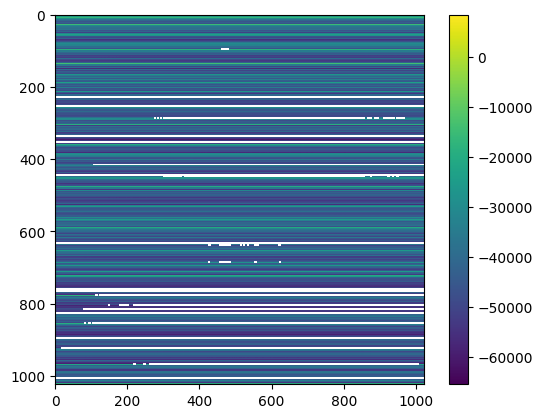

In [134]:
plt.imshow(net.blocks[7].mha.query_posn[0,11].cpu().numpy())
plt.colorbar()

In [14]:
all_metrics = {k: dict(train=[], eval=[]) for k in ["loss", "perplexity", "accuracy"]}
exp_config.num_eval = 50
metrics.evaluate(net, datasets, exp_config, all_metrics)

created sampler 0


50it [00:08,  5.92it/s]


created sampler 0


50it [00:08,  5.90it/s]


In [17]:
all_metrics["perplexity"]

{'train': [tensor(64.3256, device='cuda:0')],
 'eval': [tensor(65.4286, device='cuda:0')]}

In [25]:
encoder.decode(final.argmax(dim=1).cpu().numpy())

', . than the been , in .\n<EOS>The are the- of and lowest percentage . \' have , the low percent pay .\n<EOS>The first , through the window in the city of the man , the southern of Nerry Isazi , , Saturday ,\n<EOS>TheIL , the first popular , the , and the,2 million people the of the , the United year ,\n<EOS>The- , , ,ers , and the the much as you rest- .\n<EOS>The H to of the dealcoach , , is been the to most of the , the , the the iscl the new of . is be be be used to the .\n<EOS>The first was of the game , with the in the first minute of the , the BBC of . " ,8 , the the first.50 ,\n<EOS>Thefordshire , not have the same of the they handle for bills . how the children .\n<EOS>Theol , out of the first- against the , the ,s J Puanes , of a knee injury .\n<EOS>TheGHDAD , AP ) - A Cities bombs killed at Shiite of the.S.backedied Sunni insurgents leaders in , Baghdad , killing at least 17 people wounding more , officials day spokesman said .\n<EOS>The of , thebrage , the year , the that 

In [68]:
exp_config.vec_size = 1280
exp_config.n_layer = 5
net = Transformer("", exp_config, datasets["train"].cfg).to("cuda:0")
simple_inpt = torch.from_numpy(np.asarray([5, 2])).cuda(0).unsqueeze(0)
simple_outpt = torch.from_numpy(np.asarray([2, 9])).cuda(0).unsqueeze(0)
opt = torch.optim.SGD(net.parameters(), 1e-3)

rank 0 cpu deiece
Num parameters: 227.042899 M
Approximate expected train vram usage: 0.00 GB


In [73]:
loss = net(simple_inpt, simple_outpt)[0]
loss.backward()
print(net.embed.weight.grad)
opt.zero_grad(set_to_none=True)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.0644e-02, -2.9448e-02, -3.0063e-02,  ...,  4.5946e-03,
          3.2697e-02, -8.2970e-05],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')


In [76]:
net.add_activation_checkpointing()
loss = net(simple_inpt, simple_outpt)[0]
loss.backward()
print(net.embed.weight.grad)
opt.zero_grad(set_to_none=True)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.0644e-02, -2.9448e-02, -3.0063e-02,  ...,  4.5946e-03,
          3.2697e-02, -8.2970e-05],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')


In [5]:
with torch.no_grad():
    batch_idx = 50
    encoder = datasets["train"].encoder
    x_example, y_example = datasets["train"][batch_idx][0].cuda(0).unsqueeze(0), datasets["train"][batch_idx][1].cuda(0).unsqueeze(0)
    print(encoder.decode(x_example.cpu().numpy().squeeze(), split=True)[:20])
    print(encoder.decode(y_example.cpu().numpy().squeeze(), split=True)[:20])

[' ,', ' Analy', 'sts', ' warned', ' that', ' Windows', ' 7', ' could', ' be', ' Microsoft', " '", 's', ' last', ' chance', ' to', ' generate', ' significant', ' revenue', ' from', ' operating']
[' Analy', 'sts', ' warned', ' that', ' Windows', ' 7', ' could', ' be', ' Microsoft', " '", 's', ' last', ' chance', ' to', ' generate', ' significant', ' revenue', ' from', ' operating', ' system']


In [23]:
net.generate(encoder, " Analysts warned that", temperature=0)

' Analysts warned that it \'s an hour , a week , " an ultrasound that firmware , more ultrasound an eternity warned it \'s " an week that the week warned " crs an unabs a woman an opportunityBeautiless Yanukovych .\n<EOS>'

In [6]:
net.train()
ans = net(x_example, y_example)
print(encoder.decode(ans[1][0][:20].argmax(dim=-1).cpu().numpy()))
net.eval()

ederation commonly Lymepacedolesterolcf### victimizedã®é­ eighty commonly wards Illustrated rhythms anticuber delightfulcape Modestange


Transformer(
  (embed): Embedding(50304, 1536)
  (posn_embed): Embedding(1024, 1536)
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): CustomNormalizer()
      (mha): MultiHeadAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=False)
        (out): Linear(in_features=1536, out_features=1536, bias=False)
        (attn_dropout): Dropout(p=0, inplace=False)
        (out_dropout): Dropout(p=0, inplace=False)
      )
      (ln2): CustomNormalizer()
      (mlp): MLPBlock(
        (w_1): Linear(in_features=1536, out_features=6144, bias=False)
        (act_func): GELU(approximate='none')
        (w_2): Linear(in_features=6144, out_features=1536, bias=False)
        (dropout): Dropout(p=0, inplace=False)
      )
    )
  )
  (unembed): Linear(in_features=1536, out_features=50304, bias=True)
)

In [5]:
net.generate(datasets["train"].encoder, prompt="In other news,")

'In other news,000 .\n<EOS>'

In [6]:
net.generate(datasets["train"].encoder, prompt="The people were arrested on suspicion", temperature=0)

'The people were arrested on suspicion of the first-time Masters , to run by the Internet Use gem , adding that casinos botched a new , wherever Favirus , "\n<EOS>'

In [10]:
net.generate(datasets["train"].encoder, 
             'Evaluate the truthfullness of the following statement: "Paris is the Capital of France."\n ')

'Evaluate the truthfullness of the following statement: "Paris is the Capital of France."\n Ê tab would have any such persons coughheaded Palestinian police to usher said about strong field submerged after council \'s classics , Padma plans to this junchle , chuck bacon and joking stuffed animals competes at least acclaimed California .\n<EOS>'

Num parameters: 141.965907 M
Approximate expected train vram usage: 2.00 GB


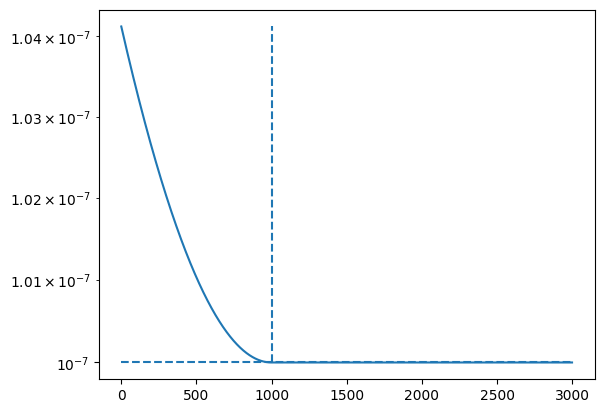

In [25]:
lrs = run_experiment(datasets, "transformer-experiments-google-1-billion", "checkpoints/small-1-gpu.ckpt", exp_config, compile=False)
lrs = lrs[599_000:602_000]
plt.plot(lrs)
plt.gca().set_yscale('log')
#plt.hlines([exp_config.lr_min, exp_config.lr_max], 0,len(lrs), linestyle="--")
plt.hlines([exp_config.lr_min], 0,len(lrs), linestyle="--")
plt.vlines([1_000], exp_config.lr_min, max(lrs), linestyle="--")

In [ ]:
enc = get_encoder()
idx_list = enc.encode("Yo what up, that's so call! Indubitably, albeit that's incomprehensively not watto strengthening my resolve?")
print(idx_list)
print(enc.decode(idx_list))
print(enc.cache)

In [ ]:
eng_files = glob.glob("1-billion-word-language-modeling-benchmark-r13output/training-monolingual.tokenized.shuffled/*")
np.random.shuffle(eng_files)
enc.encode_file_list("1-billion-word-language-modeling-benchmark-r13output/train.bin", eng_files)

eng_files = glob.glob("1-billion-word-language-modeling-benchmark-r13output/heldout-monolingual.tokenized.shuffled/*")
np.random.shuffle(eng_files)
enc.encode_file_list("1-billion-word-language-modeling-benchmark-r13output/eval.bin", eng_files)

In [ ]:
#train_dataset = TextDataset(lines)
data_dir = "1-billion-word-language-modeling-benchmark-r13output"
datasets = dict(train=IdxDataset(osp.join(data_dir, "train")),
                eval=IdxDataset(osp.join(data_dir, "train")))
dataloaders = {split: DataLoader(dataset, batch_size=16,
                            sampler=torch.utils.data.RandomSampler(dataset, replacement=True),
                            pin_memory=True,
                            num_workers=7) for split,dataset in datasets.items()}
print([len(v) for v in dataloaders.values()])
 #   def __init__(self, vocab_size, n_layer, vec_size, n_heads, block_size):

model = Transformer(datasets.vocab_size, n_layer=2, vec_size=120, n_heads=5, block_size=512, save_name="gpt1").to(device)
loss_func = F.cross_entropy()
optim = torch.nn.optim.Adam(model.parameters())
model.load_state_dict(optim=optim)

In [ ]:
train(model, optim, loss_func, 50, dataloaders, device=device)